# Tensor network

MPS Tutorials:
- [ITensors](https://itensor.github.io/ITensors.jl/dev/examples/MPSandMPO.html)
- [MPSKit](https://quantumkithub.github.io/MPSKit.jl/dev/examples/quantum1d/3.ising-dqpt/#DQPT-in-the-Ising-model(@id-demo_dqpt))

## A first TEBD Example

`pip install physics-tenpy`

Like `examples/c_tebd.py`, this notebook shows the basic interface for TEBD.
It initalized the transverse field Ising model $H = J XX + g Z$ at the critical point $J=g=1$,
and an MPS in the all-up state $|\uparrow\cdots \uparrow\rangle$.
It then performs a real-time evolution with TEBD and measures a few observables.
This setup correspond to a global quench from $g =\infty$ to $g=1$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 100

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.linalg import np_conserved as npc
from tenpy.algorithms import tebd
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain

# tenpy.tools.misc.setup_logging(to_stdout="INFO")

In [3]:
L = 20

In [4]:
model_params = {
    'J': 1. , 'g': 1.,  # critical
    'L': L,
    'bc_MPS': 'finite',    
}

M = TFIChain(model_params)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/tenpy/networks/site.py:1227: FutureWarning: LegCharge of physical leg in site SpinHalfSite('parity') is not sorted. You should explicitly set `sort_charge`. Set it to False, if you already have saved data for your model and want to be able to load it/keep backwards compatibility. For new projects, if you don't have data yet, set it to `True`. We will switch the default from False to True in version 1.0, which breaks compatibility of existing data with code/models that don't explicitly set sort_legcharge.
  Site.__init__(self, leg, ['up', 'down'], sort_charge=sort_charge, **ops)


In [5]:
psi = MPS.from_lat_product_state(M.lat, [['up']])

In [6]:
tebd_params = {
    'N_steps': 1,
    'dt': 0.1,
    'order': 4,
    'trunc_params': {'chi_max': 100, 'svd_min': 1.e-12}
}
eng = tebd.TEBDEngine(psi, M, tebd_params)

In [7]:
def measurement(eng, data):
    keys = ['t', 'entropy', 'Sx', 'Sz', 'corr_XX', 'corr_ZZ', 'trunc_err']
    if data is None:
        data = dict([(k, []) for k in keys])
    data['t'].append(eng.evolved_time)
    data['entropy'].append(eng.psi.entanglement_entropy())
    data['Sx'].append(eng.psi.expectation_value('Sigmax'))
    data['Sz'].append(eng.psi.expectation_value('Sigmaz'))
    data['corr_XX'].append(eng.psi.correlation_function('Sigmax', 'Sigmax'))
    data['trunc_err'].append(eng.trunc_err.eps)
    return data

In [8]:
data = measurement(eng, None)

In [9]:
while eng.evolved_time < 5.:
    eng.run()
    measurement(eng, data)

KeyboardInterrupt: 

Text(0, 0.5, 'entropy $S$')

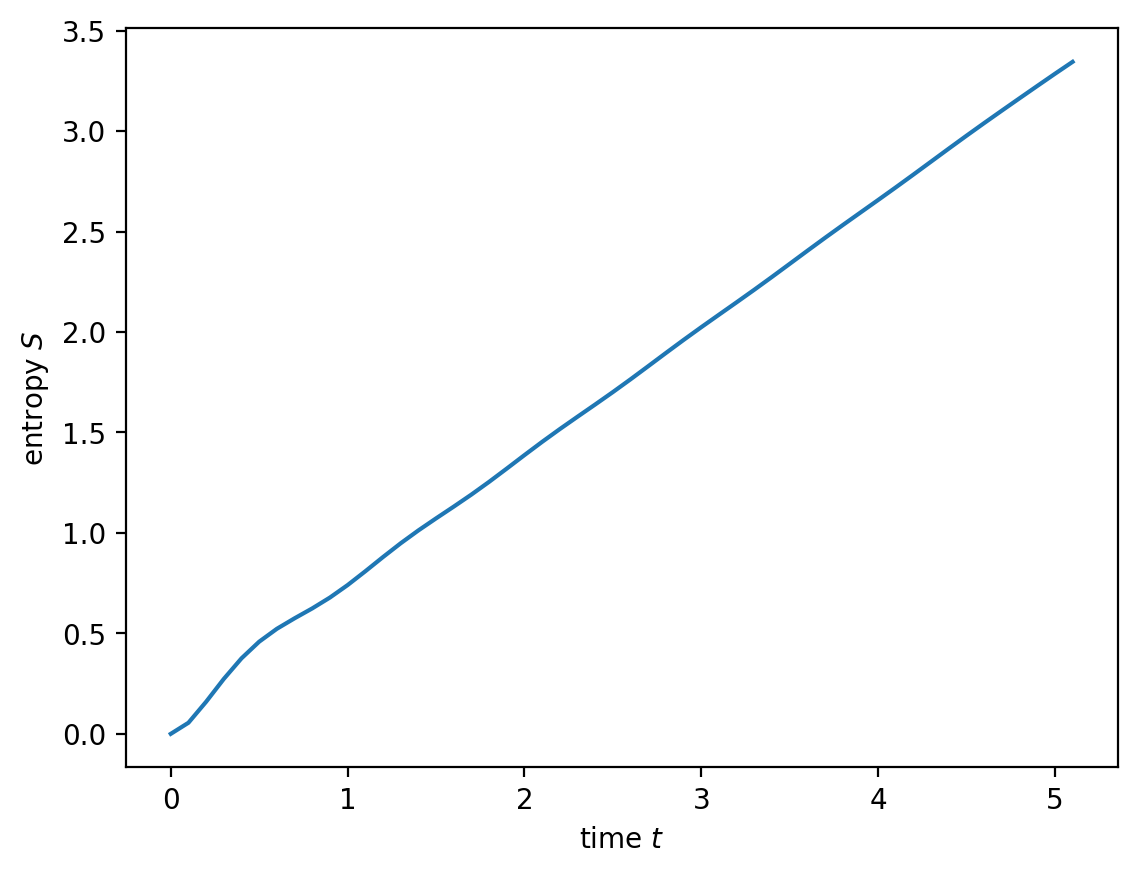

In [11]:
plt.plot(data['t'], np.array(data['entropy'])[:, L//2])
plt.xlabel('time $t$')
plt.ylabel('entropy $S$')

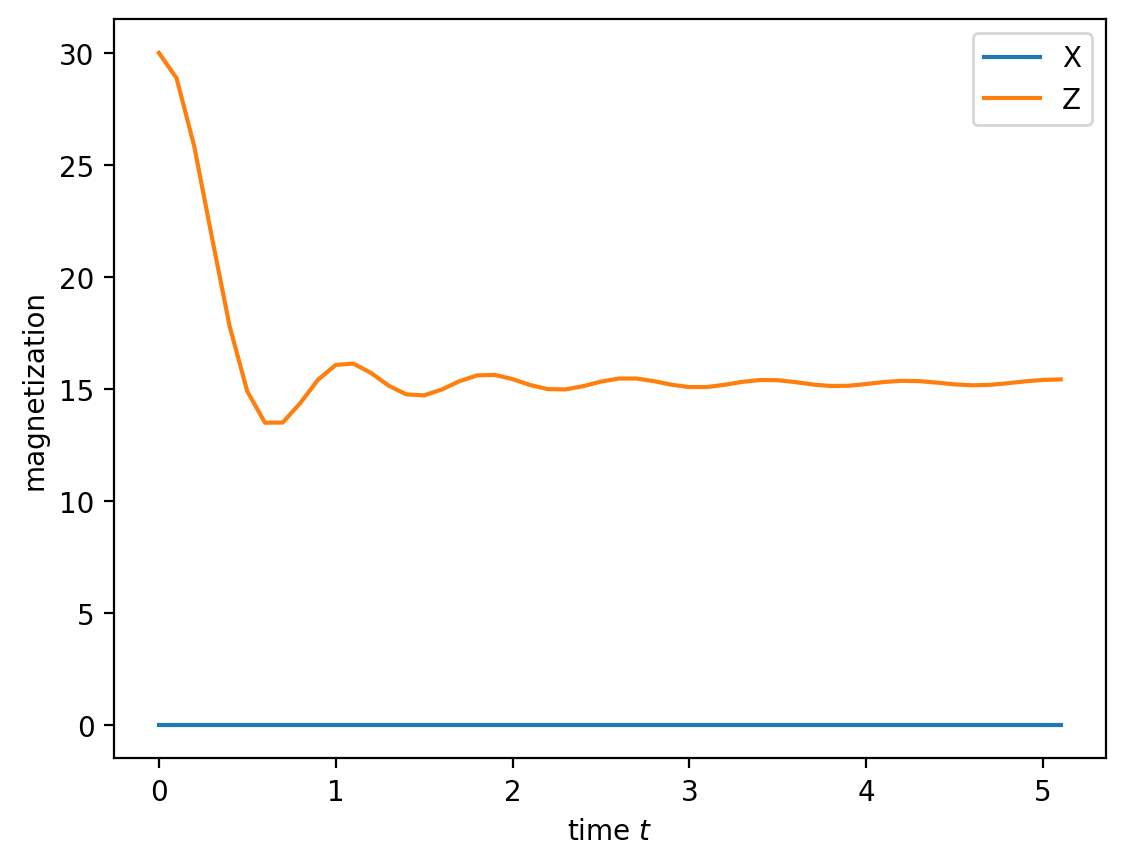

In [12]:
plt.plot(data['t'], np.sum(data['Sx'], axis=1), label="X")
plt.plot(data['t'], np.sum(data['Sz'], axis=1), label="Z")

plt.xlabel('time $t$')
plt.ylabel('magnetization')
plt.legend(loc='best')

The strict conservation of `X` being zero is ensured by charge conservation, because `X` changes the parity sector.

Nevertheless, the `XX` correlation function can be nontrivial:


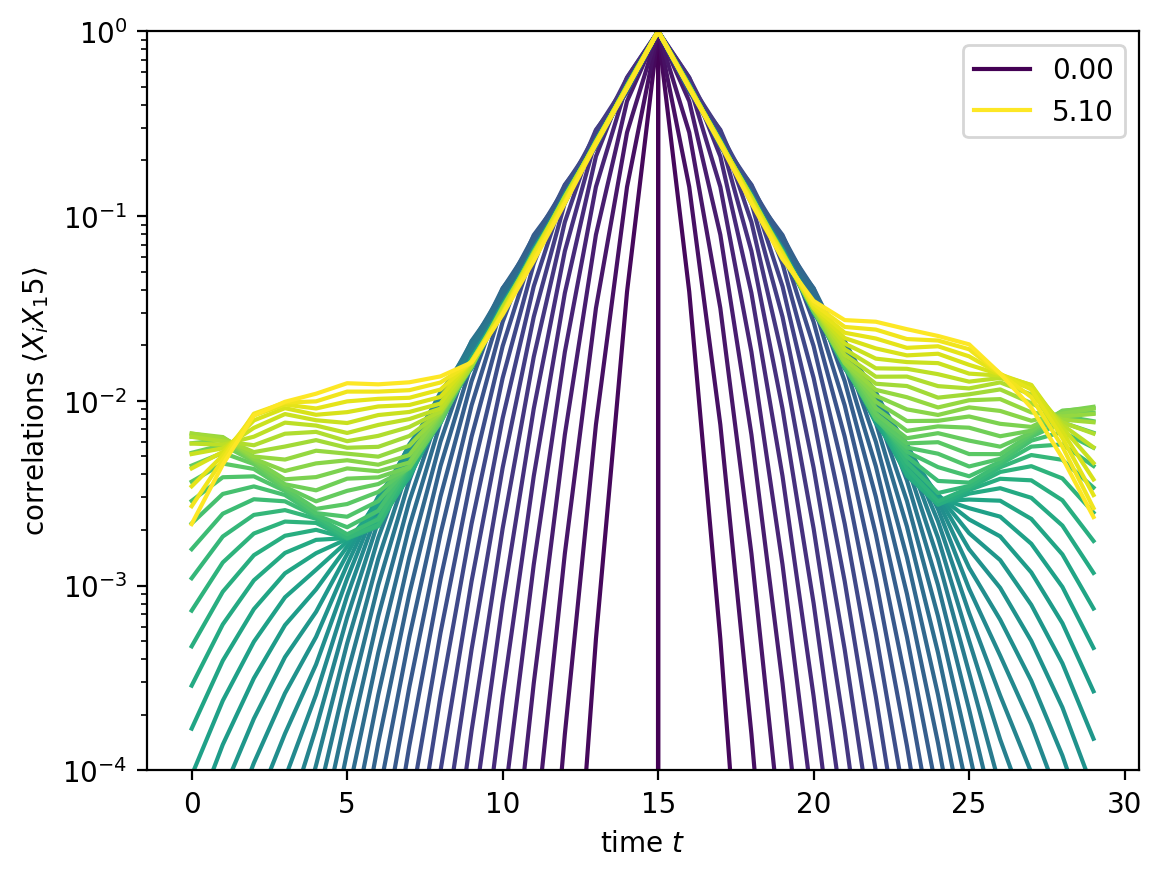

In [13]:
corrs = np.array(data['corr_XX'])
tmax = data['t'][-1]
x = np.arange(L)
cmap = matplotlib.cm.viridis
for i, t in list(enumerate(data['t'])):
    if i == 0 or i == len(data['t']) - 1:
        label = '{t:.2f}'.format(t=t)
    else:
        label = None
    plt.plot(x, corrs[i, L//2, :], color=cmap(t/tmax), label=label)

plt.xlabel(r'time $t$')
plt.ylabel(r'correlations $\langle X_i X_{j:d}\rangle$'.format(j=L//2))
plt.yscale('log')
plt.ylim(1.e-4, 1.)
plt.legend()
plt.show()

The output of the run showed that we gradually increased the bond dimension and only reached the maximum chi around $t=2.5$. At this point we start to truncate significantly, because we cut off the tail whatever the singular values are. This is clearly visible if we plot the truncation error vs. time below. Note the log-scale, though: if you are fine with an error of say 1 permille for expectation values, you can still go on for a bit more!

Text(0, 0.5, 'truncation error')

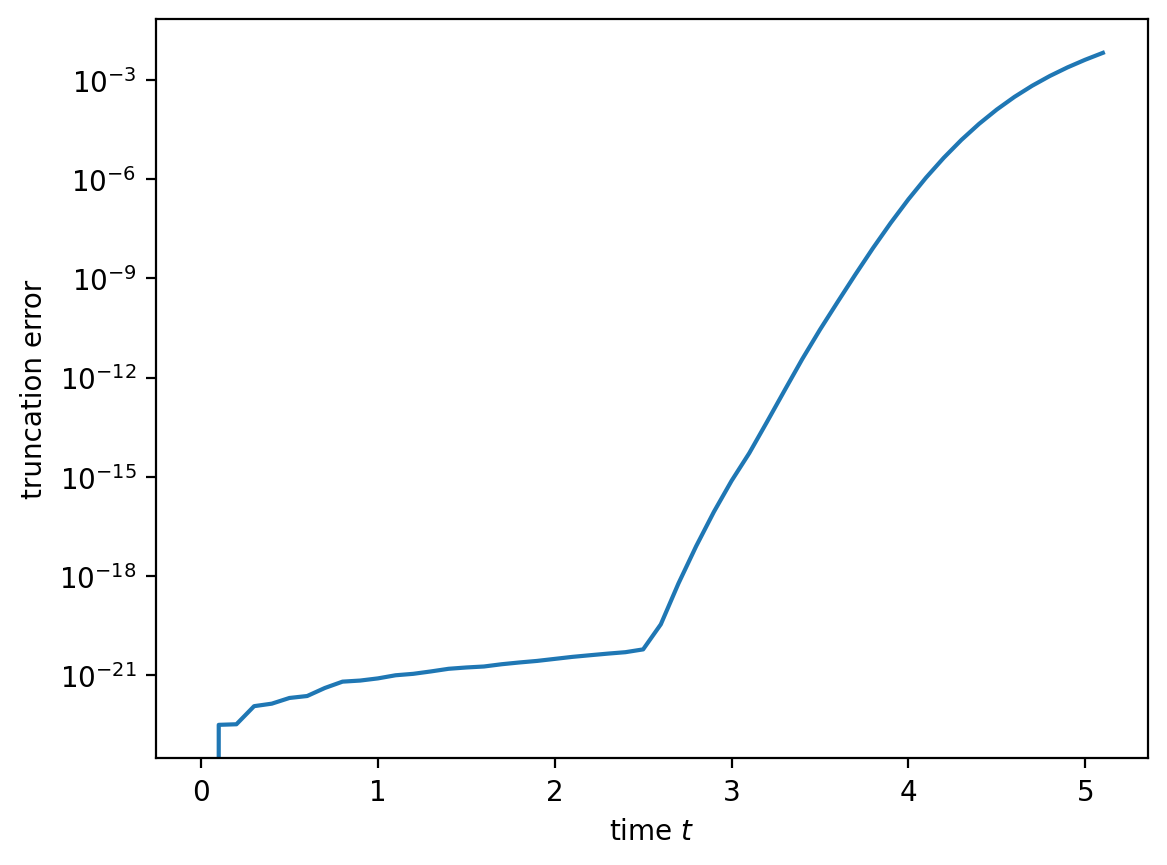

In [14]:
plt.plot(data['t'], data['trunc_err'])

plt.yscale('log')
#plt.ylim(1.e-15, 1.)
plt.xlabel('time $t$')
plt.ylabel('truncation error')